# Brief description of the problem and data 

Objective is to build a model that predicts which Tweets are about real disasters and which one’s aren’t.
In data 10,000 tweets were hand classified.

Results are evaluted based on F1 score of the model.

Data is available on kaggle : https://www.kaggle.com/competitions/nlp-getting-started/data

Above link contains 3 files:
 * Train file : we use this file to train model
 * Test file : Use this data to test our model
 * Sample submission : This is the format of submission file which we need to upload on kaggle

In train data we have 7613 tweets, to test your model we have 3263 tweets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_df1 = pd.read_csv(r'/Users/vishalverma/Vishal/Github_project/Twitter-Sentiment-NLP/Data/train.csv')
test_df1 = pd.read_csv(r'/Users/vishalverma/Vishal/Github_project/Twitter-Sentiment-NLP/Data/test.csv')
sample_df1 = pd.read_csv(r'/Users/vishalverma/Vishal/Github_project/Twitter-Sentiment-NLP/Data/sample_submission.csv')

___________

# Exploratory Data Analysis (EDA)

In [10]:
train_df1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [18]:
(train_df1.isna().sum()/train_df1.shape[0])*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

As we can see from above table location has 33% missing values

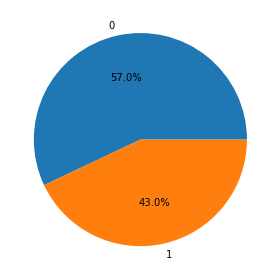

In [28]:
plt.pie(train_df1.target.value_counts(),labels = train_df1.target.value_counts().index,autopct='%.1f%%')
plt.tight_layout()

43% of tweets are categorised as disaster tweet whereas 57% are categorised as non disater tweet.